<a href="https://colab.research.google.com/github/mhuertascompany/EDE20/blob/master/Ouverte/Sersic_Reff_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GALAXY SIZES WITH CNNs AND TENSORFLOW PROBABILITY

The purpose of this tutorial is to estimate galaxy half light radii of galaxies from images. Galaxy sizes are traditionnally estimated by fitting a [PSF-convolved Sersic model](https://users.obs.carnegiescience.edu/peng/work/galfit/galfit.html) to galaxy images. We are going to use a CNN instead. The network takes then as input a galaxy image convolved with a PSF and outputs its effective radius. The same approach can be used to estiamte other parameters such as ellipticiites. See [Tuccillo+18](http://adsabs.harvard.edu/abs/2018MNRAS.475..894T) for an illustration. In this tutorial we are going a step further by estimating the posterior distribution of sizes instead of a single point estimate. The posterior is modeled with a gaussian mixture model using TF probability.

![](https://drive.google.com/uc?id=1R9ITrzxUG0X9VjwFUhbbwsDhZD8A4ANy)

---



#### Before we start, make sure to open this Colab notebook in "PlayGround Mode" (top left) and to change the Runtime type to GPU by navigating to the toolbar and clicking Runtime -> Change runtime type and then changing Hardware accelerator to GPU

---





## Import packages


In [ ]:
import os
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_probability
import numpy as np
tfd = tensorflow_probability.distributions
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pdb
import pickle
from astropy.io import fits
from astropy.visualization.stretch import SqrtStretch
from astropy.visualization import ImageNormalize, MinMaxInterval

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data download and preparation

Before mounting the drive click on [this folder](https://drive.google.com/drive/folders/1PcftgBzBySo1Ync-Wdsp9arTCJ_MfEPE?usp=sharing) and add it to your google drive by following these steps:

*   Go to your drive 
*   Find shared folder ("Shared with me" link)
*   Right click it
*   Click Add to My Drive



Mount your drive into Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Then load the data for training. The dataset (X) contains 2 numpy arrays with the galaxy images (128*128 pixels) and the known effective radii for every galaxy. For the training we are using Single Sersic Models convolved with an HST PSF and with real HST noise added. The effective size of the modeled galaxies is thus known and stored in vector Y. The goal is to estimate Y from X.

In [ ]:
#Load data
pathinData="/content/drive/My Drive/EDE2019/sizes"

#images
X = np.load(pathinData+'/Stamps_Simulated_Galaxies_tutorial.npy')

#sizes
Y = np.load(pathinData+'/Parameters_Simulated_Galaxies_tutorial.npy') 


In [ ]:
# rescaling the sizes with mean and variance
Y=Y.reshape(-1,1)
Y_o=np.copy(Y)
s=np.std(Y)
u=np.mean(Y)
Y=(Y-u)/s

# Spliting in Training and Test datasets, 4/5 of galaxies for training, 1/5 for testing
x_train = X[0:len(X)//5*4,0,:,:]   
x_test = X[len(X)//5*4:,0,:,:]
t_train = Y[0:len(Y)//5*4,:]
t_test = Y[len(Y)//5*4:,:]
print ('Y_train.shape= ', t_train.shape)          
print(np.max(t_train),np.min(t_train))




Y_train.shape=  (24000, 1)
3.442385654670674 -1.0533185553849191


## Visualize images

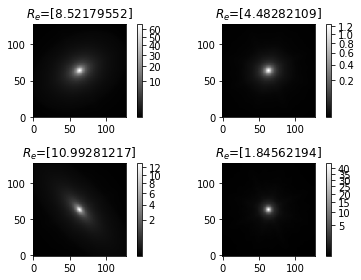

In [ ]:
stretch = SqrtStretch() 

randomized_inds_train = np.random.permutation(len(x_train))


fig = plt.figure()
for i,j in zip(randomized_inds_train[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(x_train[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(x_train[i,:,:], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(Y_o[i]))
  fig.tight_layout() 
  fig.colorbar(im)


## Model Setup

The follwing cells define the neural network architecture. We use here the Tensorflow Esitmator API. The function _mdn_model_fn defines the model. It is made of 6 convolutional layers with some pooling operations. The output of the convolutional part is then fed into a fully connected NN which estimates the scales, means and standard deviations of the gaussian PDFs of the mixture model. The proposed version is found to be quite stable. However, feel free to modify.

In [ ]:
def _mdn_model_fn(features, labels, network_fn, n_mixture, diag,
               feature_columns, label_columns, optimizer, activation_fn, normalizer_fn, dropout, mode):

    #Parameters of the model that can be modified
    nfilters=16
    
    
    # Check for training mode
    is_training = mode == tf.estimator.ModeKeys.TRAIN
    label_dimension=len(label_columns)
   
    # Input Layer
    print(features)
    regularizer = slim.l2_regularizer(0.001)
    input_layer = tf.reshape(features, [-1, 128, 128, 1])
    

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=nfilters,
      kernel_size=[4, 4],
      padding="same",
      activation=tf.nn.relu)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
      inputs=conv1,
      filters=nfilters,
      kernel_size=[4, 4],
      padding="same",
      activation=tf.nn.relu)
    
    # Dropout
    tf.nn.dropout(conv2,rate=0.15)

    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Convolutional Layer #3
    conv3 = tf.layers.conv2d(
      inputs=pool1,
      filters=nfilters*4,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Convolutional Layer #4
    conv4 = tf.layers.conv2d(
      inputs=conv3,
      filters=nfilters*4,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    pool2=tf.layers.max_pooling2d(inputs=conv4, pool_size=[2, 2], strides=2)

    # Convolutional Layer #5
    conv5 = tf.layers.conv2d(
      inputs=pool2,
      filters=nfilters*4,
      kernel_size=[2, 2],
      padding="same",
      activation=tf.nn.relu)

    # Convolutional Layer #6
    conv6 = tf.layers.conv2d(
      inputs=conv5,
      filters=nfilters*4,
      kernel_size=[2, 2],
      padding="same",
      activation=tf.nn.relu)
    
    # Pooling Layer #3
    pool3=tf.layers.max_pooling2d(inputs=conv6, pool_size=[2, 2], strides=2)

    # This layer flattens the features extracted by the convolutional layers
    pool4_flat = tf.layers.flatten(pool3)
    
    #Dense network to estimate a "Summary Statistics" from the signal
    dense1 = slim.fully_connected(pool4_flat, 128, activation_fn=tf.nn.leaky_relu)
    dense2 = slim.fully_connected(dense1, 64, activation_fn=tf.nn.leaky_relu)
    stat = slim.fully_connected(dense2, 1, activation_fn=None,weights_regularizer=regularizer) #  
    
    
    # Expand the network from the summary statistics and estimate mixture components
    net = slim.fully_connected(stat, 64, activation_fn=tf.nn.tanh)

    
    
    # Size of the covariance matrix
    if diag ==True:
        size_sigma = label_dimension
        
    else:
        size_sigma = (label_dimension *(label_dimension +1) // 2)
        
    # Create mixture components from network output
    out_mu = slim.fully_connected(net, label_dimension*n_mixture , activation_fn=None)
    out_mu = tf.reshape(out_mu, (-1, n_mixture, label_dimension))

    out_sigma = slim.fully_connected(net, size_sigma * n_mixture, activation_fn=None)
    out_sigma = tf.reshape(out_sigma, (-1, n_mixture, size_sigma))

    out_p = slim.fully_connected(net, n_mixture, activation_fn=None)

    if diag == True:
        sigma_mat = tf.nn.softplus(out_sigma)+1e-3
        gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=out_p),
                      components_distribution=tfd.MultivariateNormalDiag(loc=out_mu,
                                                                        scale_diag=sigma_mat))
    else:
        sigma_mat = tfd.matrix_diag_transform(tfd.fill_triangular(out_sigma), transform=tf.nn.softplus)
        gmm = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=out_p),
                     components_distribution=tfd.MultivariateNormalTriL(loc=out_mu,
                                                                        scale_tril=sigma_mat))

    predictions = {'mu': out_mu, 'sigma': sigma_mat, 'p':out_p, 'stat':stat}

    if mode == tf.estimator.ModeKeys.PREDICT:
        y = gmm.sample(2000)
        samples = y
        predictions['samples'] = tf.transpose(y,[1,0,2])

        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,
                                          export_outputs={'pdf': tf.estimator.export.PredictOutput(predictions),
                                                          'samples': tf.estimator.export.PredictOutput(samples),
                                                          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: tf.estimator.export.PredictOutput(samples)})

    label_layer = labels
    

    # Compute and register loss function
    loss = - tf.reduce_mean(gmm.log_prob(label_layer),axis=0)
    tf.losses.add_loss(loss)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=True)

    train_op = None
    eval_metric_ops = None

   
    # Define optimizer
    if mode == tf.estimator.ModeKeys.TRAIN:
        tf.summary.scalar('total loss', total_loss)
        tf.summary.histogram('Output-Input Distribution',tf.reduce_mean(gmm.sample(2000),axis=0)-labels)
        mse=tf.reduce_mean(tf.square(tf.reduce_mean(gmm.sample(2000),axis=0)-labels))
        tf.summary.scalar('R2', 1. - mse/tf.square(tf.math.reduce_std(labels)))
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer(learning_rate=0.00002).minimize(loss=total_loss,
                                        global_step=tf.train.get_global_step())
       
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = { "log_p": loss}

    return tf.estimator.EstimatorSpec(mode=mode,
                                      predictions=predictions,
                                      loss=total_loss,
                                      train_op=train_op,
                                      eval_metric_ops=eval_metric_ops)



In [ ]:
class MDNEstimator(tf.estimator.Estimator):
    """An estimator for distribution estimation using Mixture Density Networks.
    """

    def __init__(self,
               feature_columns,
               label_columns,
               network_fn,
               n_mixture,
               diagonal=True,
               optimizer=tf.train.AdamOptimizer,
               activation_fn=tf.nn.relu,
               normalizer_fn=slim.batch_norm,
               dropout=None,
               model_dir=None,
               config=None):
        """Initializes a `MDNEstimator` instance.
        """

        def _model_fn(features, labels, mode):
            return _mdn_model_fn(features, labels, network_fn, n_mixture, diagonal,
               feature_columns, label_columns, optimizer, activation_fn, normalizer_fn, dropout, mode)

        super(self.__class__, self).__init__(model_fn=_model_fn,
                                             model_dir=model_dir,
                                             config=config)

The follwing cell defines two input functions for training and testing. A mapping is used in order not to load all iamges in memory at the same time. Just compile this cell - No need to understand or modify at this stage.

In [ ]:
 ####
batch_size=32

# Define input function for training 
def input_fn_train():
    def mapping_function(x):
        def extract_batch(inds):
            randomized_inds_train = np.random.permutation(len(x_train))
            inds = randomized_inds_train[inds]
            #pdb.set_trace()
            return x_train[inds].astype('float32'), t_train[inds].astype('float32')
        a,b =tf.py_func(extract_batch, [x], [tf.float32,tf.float32])
        #pdb.set_trace()
        a.set_shape([None, 128,128]) # or whatever the  size of the images is 
        b.set_shape([None, 1]) # Assuming you are trying tot predict one parametter
        return a,b
    dataset = tf.data.Dataset.range(len(x_train))
    
    dataset = dataset.repeat().batch(batch_size)
    dataset = dataset.map(mapping_function)
    iterator = dataset.make_one_shot_iterator()
    #im, label = iterator.get_next()
    #pdb.set_trace()
    return dataset


def input_fn_test():
    def mapping_function(x):
        def extract_batch(inds):
            #randomized_inds_test = np.random.permutation(len(x_test))
            #inds = randomized_inds_test[inds]
            #pdb.set_trace()
            return x_test[inds].astype('float32'), t_test[inds].astype('float32')
        a,b =tf.py_func(extract_batch, [x], [tf.float32,tf.float32])
        #pdb.set_trace()
        a.set_shape([None, 128,128]) # or whatever the  size of the images is 
        b.set_shape([None, 1]) # Assuming you are trying tot predict one parametter
        return a,b
    dataset = tf.data.Dataset.range(len(x_test))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(mapping_function)
    iterator = dataset.make_one_shot_iterator()
    #im, label = iterator.get_next()
    #pdb.set_trace()
    return dataset
  
def input_fn_real():
    def mapping_function(x):
        def extract_batch(inds):
            #randomized_inds_test = np.random.permutation(len(x_test))
            #inds = randomized_inds_test[inds]
            #pdb.set_trace()
            return X_real[inds].astype('float32'), Y_real[inds].astype('float32')
        a,b =tf.py_func(extract_batch, [x], [tf.float32,tf.float32])
        #pdb.set_trace()
        a.set_shape([None, 128,128]) # or whatever the  size of the images is 
        b.set_shape([None, 1]) # Assuming you are trying tot predict one parametter
        return a,b
    dataset = tf.data.Dataset.range(len(X_real))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(mapping_function)
    iterator = dataset.make_one_shot_iterator()
    #im, label = iterator.get_next()
    #pdb.set_trace()
    return dataset  

## Training and Predicting
The code starts here. 

In [ ]:
#Define output path - This folder will contain the trained model
pathout='models/model1'

#Set RESET=True to delete all previous runs of the same model
RESET=False
if RESET:
  tf.summary.FileWriterCache.clear()
  !rm -rf pathout

We first train the model for 1000 steps. This is only a trick to be able to use TensorBoard within the notebook. The current implementation uses 2 mixture models. This can be modified.

In [ ]:
max_steps=1000
features = ['x']
labels = ['size']

model = MDNEstimator(features, labels, None, n_mixture=2,
               diagonal=True, model_dir=pathout)


print("First training...")
model.train(input_fn_train, max_steps=max_steps)


First training...
Tensor("IteratorGetNext:0", shape=(?, 128, 128), dtype=float32)


Then launch tensorboard. An orange panel with all TensorBoard panels should appear. If not try running the cell again.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir models/model1

Continue training. The TensorBoard panel should update automatically so that you can track the progress. The maximum number of iterations is set to 10,000 to speed up computation. However the model continues improving at leat up to 200,000 steps.

In [ ]:
max_steps=10000
features = ['x']
labels = ['size']

model = MDNEstimator(features, labels, None, n_mixture=2,
               diagonal=True, model_dir=pathout)


print("Training...")
model.train(input_fn_train, max_steps=max_steps)




Training...
Tensor("IteratorGetNext:0", shape=(?, 128, 128), dtype=float32)


W0822 12:51:17.174667 140547623393152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
W0822 12:51:17.344252 140547623393152 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1066: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


KeyboardInterrupt: ignored

We now use the saved model to estimate the sizes of galaxies in the test dataset

In [ ]:
print("Predicting")
pred = model.predict(input_fn_test)



p=[]
theta=[]
for i in range(len(t_test)):
    p.append(next(pred))
    theta.append(t_test[i])


# store output files
file_p = open(pathout+'/p.obj', 'wb') 
pickle.dump(p, file_p)
file_t = open(pathout+'/test.obj', 'wb') 
pickle.dump(theta, file_t)

Predicting
Tensor("IteratorGetNext:0", shape=(?, 128, 128), dtype=float32)


## Plotting the results
The follwing cells do some plots of the results

In [ ]:
file = open(pathout+'/p.obj','rb')
p=pickle.load(file)

file = open(pathout+'/test.obj','rb')
t=pickle.load(file)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/usr/local/lib/python3.6/dist-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


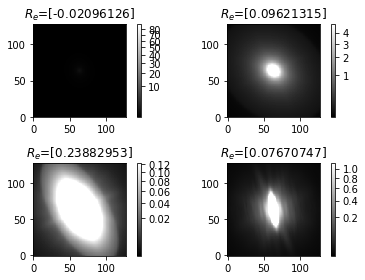

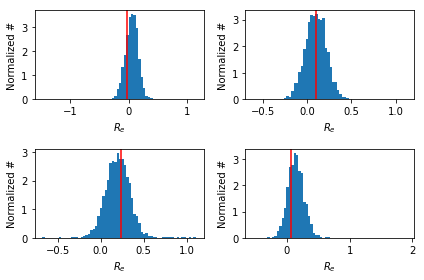

In [ ]:

stretch = SqrtStretch() 

randomized_inds_test = np.random.permutation(len(x_test))


fig = plt.figure()
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(x_train[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(x_test[i,:,:], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(t[i]))
  fig.tight_layout() 
  fig.colorbar(im)
  
fig = plt.figure()  
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  axvline(t[i],color='r', label='truth')
  hist(p[i]['samples'].flatten(),64,normed=True)
  xlabel("$R_e$")
  ylabel("Normalized #")
  fig.tight_layout()
 



(-10, 5)

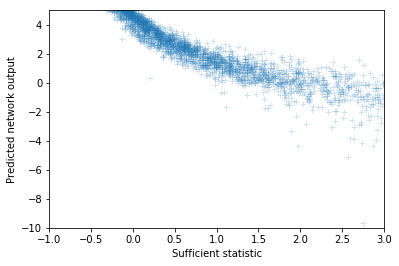

In [ ]:
st=[]
for i in range(len(p)):
    st.append(p[i]['stat'])

plot(t, st, '+',alpha=0.2)
xlabel('Sufficient statistic',fontsize=20)
ylabel('Predicted network output',fontsize=20)
xlim(-1,3)
ylim(-10,5)


(0, 20)

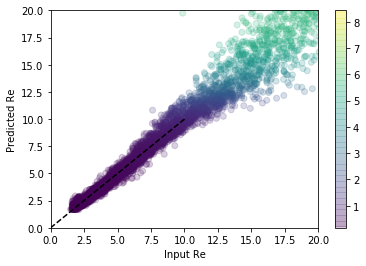

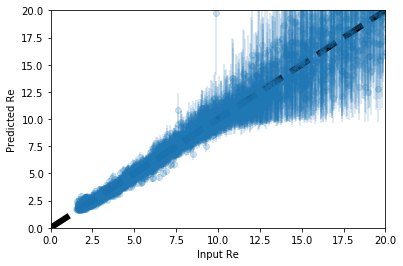

In [ ]:
st=[]
sigma=[]
for i in range(len(p)):
    st.append(np.mean(np.asarray(p[i]['samples'])*s+u))
    sigma.append(np.std(np.asarray(p[i]['samples'])*s+u))
fig = plt.figure() 
scatter(np.asarray(t)*s+u, st,c=sigma ,alpha=0.2)
plt.colorbar()
xlabel('Input Re',fontsize=20)
ylabel('Predicted Re',fontsize=20)
plot([0,10],[0,10],'k--')
xlim(0,20)
ylim(0,20)

fig = plt.figure() 
errorbar(np.asarray(t)*s+u, st,yerr=sigma ,alpha=0.2,fmt='o')
xlabel('Input Re',fontsize=20)
ylabel('Predicted Re',fontsize=20)
plot([0,20],[0,20],'k--',lw=6)
xlim(0,20)
ylim(0,20)

## Real data

In [ ]:
#images
X_real = np.load(pathinData+'/RealStamps_tutorial.npy')

#sizes
Y_real = np.load(pathinData+'/ParametersRealStamps_tutorial.npy')


X_real = X_real[:,0,:,:] 

Y_real=Y_real.reshape(-1,1)
Y_real_o=np.copy(Y_real)
Y_real=(Y_real-u)/s


(5000, 1)
(5000, 128, 128)
-0.0017166673205792904
-1648.88232421875


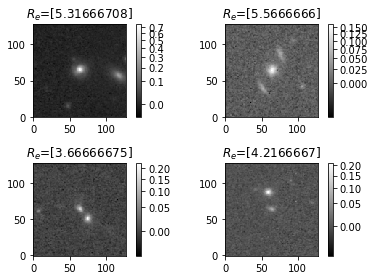

In [ ]:
print(Y_real.shape)
print(X_real.shape)

stretch = SqrtStretch() 

randomized_inds_test = np.random.permutation(len(X_real))
print(np.min(x_train))
print(np.min(X_real))

fig = plt.figure()
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(X_real[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(X_real[i,:,:], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(Y_real_o[i]))
  fig.tight_layout() 
  fig.colorbar(im)

In [ ]:
print("Predicting")
pred = model.predict(input_fn_real)



p_real=[]
theta_real=[]
for i in range(len(Y_real)):
    p_real.append(next(pred))
    theta_real.append(Y_real[i])


# store output files
file_p = open(pathout+'/p_real.obj', 'wb') 
pickle.dump(p_real, file_p)
file_t = open(pathout+'/Y_real.obj', 'wb') 
pickle.dump(theta_real, file_t)

Predicting
Tensor("IteratorGetNext:0", shape=(?, 128, 128), dtype=float32)


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


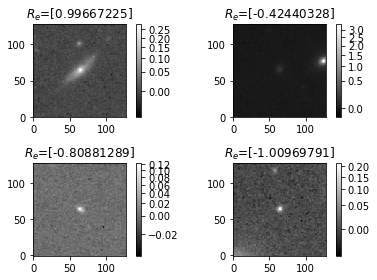

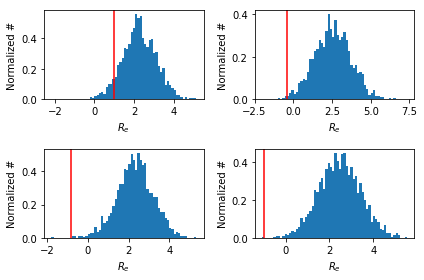

In [ ]:
file = open(pathout+'/p_real.obj','rb')
p_real=pickle.load(file)

file = open(pathout+'/Y_real.obj','rb')
t_real=pickle.load(file)

stretch = SqrtStretch() 

randomized_inds_test = np.random.permutation(len(X_real))


fig = plt.figure()
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  interval = MinMaxInterval()
  vmin, vmax = interval.get_limits(X_real[i,:,:])
  norm = ImageNormalize(stretch=stretch)
  im = ax.imshow(X_real[i,:,:], origin='lower', cmap='gray',
    vmin=vmin, norm=norm,vmax=vmax)
  plt.title('$R_e$='+str(t_real[i]))
  fig.tight_layout() 
  fig.colorbar(im)
  
fig = plt.figure()  
for i,j in zip(randomized_inds_test[0:4],range(4)):
  ax = fig.add_subplot(2, 2, j+1)
  axvline(t_real[i],color='r', label='truth')
  hist(p_real[i]['samples'].flatten(),64,normed=True)
  xlabel("$R_e$")
  ylabel("Normalized #")
  fig.tight_layout()

(0, 20)

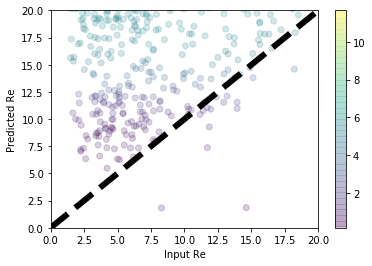

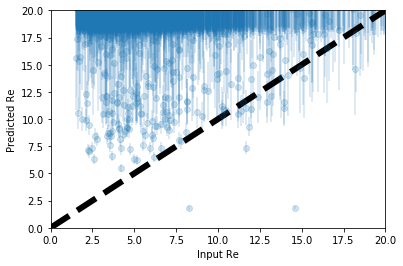

In [ ]:
st=[]
sigma=[]
for i in range(len(p_real)):
    st.append(np.mean(np.asarray(p_real[i]['samples'])*s+u))
    sigma.append(np.std(np.asarray(p_real[i]['samples'])*s+u))
fig = plt.figure() 
scatter(np.asarray(t_real)*s+u, st,c=sigma ,alpha=0.2)
plt.colorbar()
xlabel('Input Re')
ylabel('Predicted Re')
plot([0,20],[0,20],'k--',lw=6)
xlim(0,20)
ylim(0,20)

fig = plt.figure() 
errorbar(np.asarray(t_real)*s+u, st,yerr=sigma ,alpha=0.2,fmt='o')
xlabel('Input Re')
ylabel('Predicted Re')
plot([0,20],[0,20],'k--',lw=6)
xlim(0,20)
ylim(0,20)